## Vectorize ROC Curve for Bayesian Models

In this notebook, we present a simple example to illustrate how to vectorize the ROC curve computation over a Bayesian model. This is helpful when we want to compute the ROC curve using the implementations from [`scikit-learn`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html). We use the classical [moons dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) to generate the data and fit a Gaussian process models similarly as the previous post [Scikit-Learn Example in PyMC: Gaussian Process Classifier](https://juanitorduz.github.io/sklearn_pymc_classifier/).

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import preliz as pz
import pymc as pm
import pytensor
import seaborn as sns
import xarray as xr
from sklearn.datasets import make_moons
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

pytensor.config.cxx = "/usr/bin/clang++"


az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "vectorize_roc_curve"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Generate Synthetic Data

In [3]:
# Generate data
x, y = make_moons(n_samples=150, noise=0.25, random_state=seed)
# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=seed
)
# Get number of samples in training and test sets
n_train = x_train.shape[0]
n_test = x_test.shape[0]
n = n_train + n_test
# Create indices for training and test sets
idx_train = range(n_train)
idx_test = range(n_train, n_train + n_test)
# Get dimension of the domain
domain_dim = x.shape[1]

Let's start by visualizing the data.

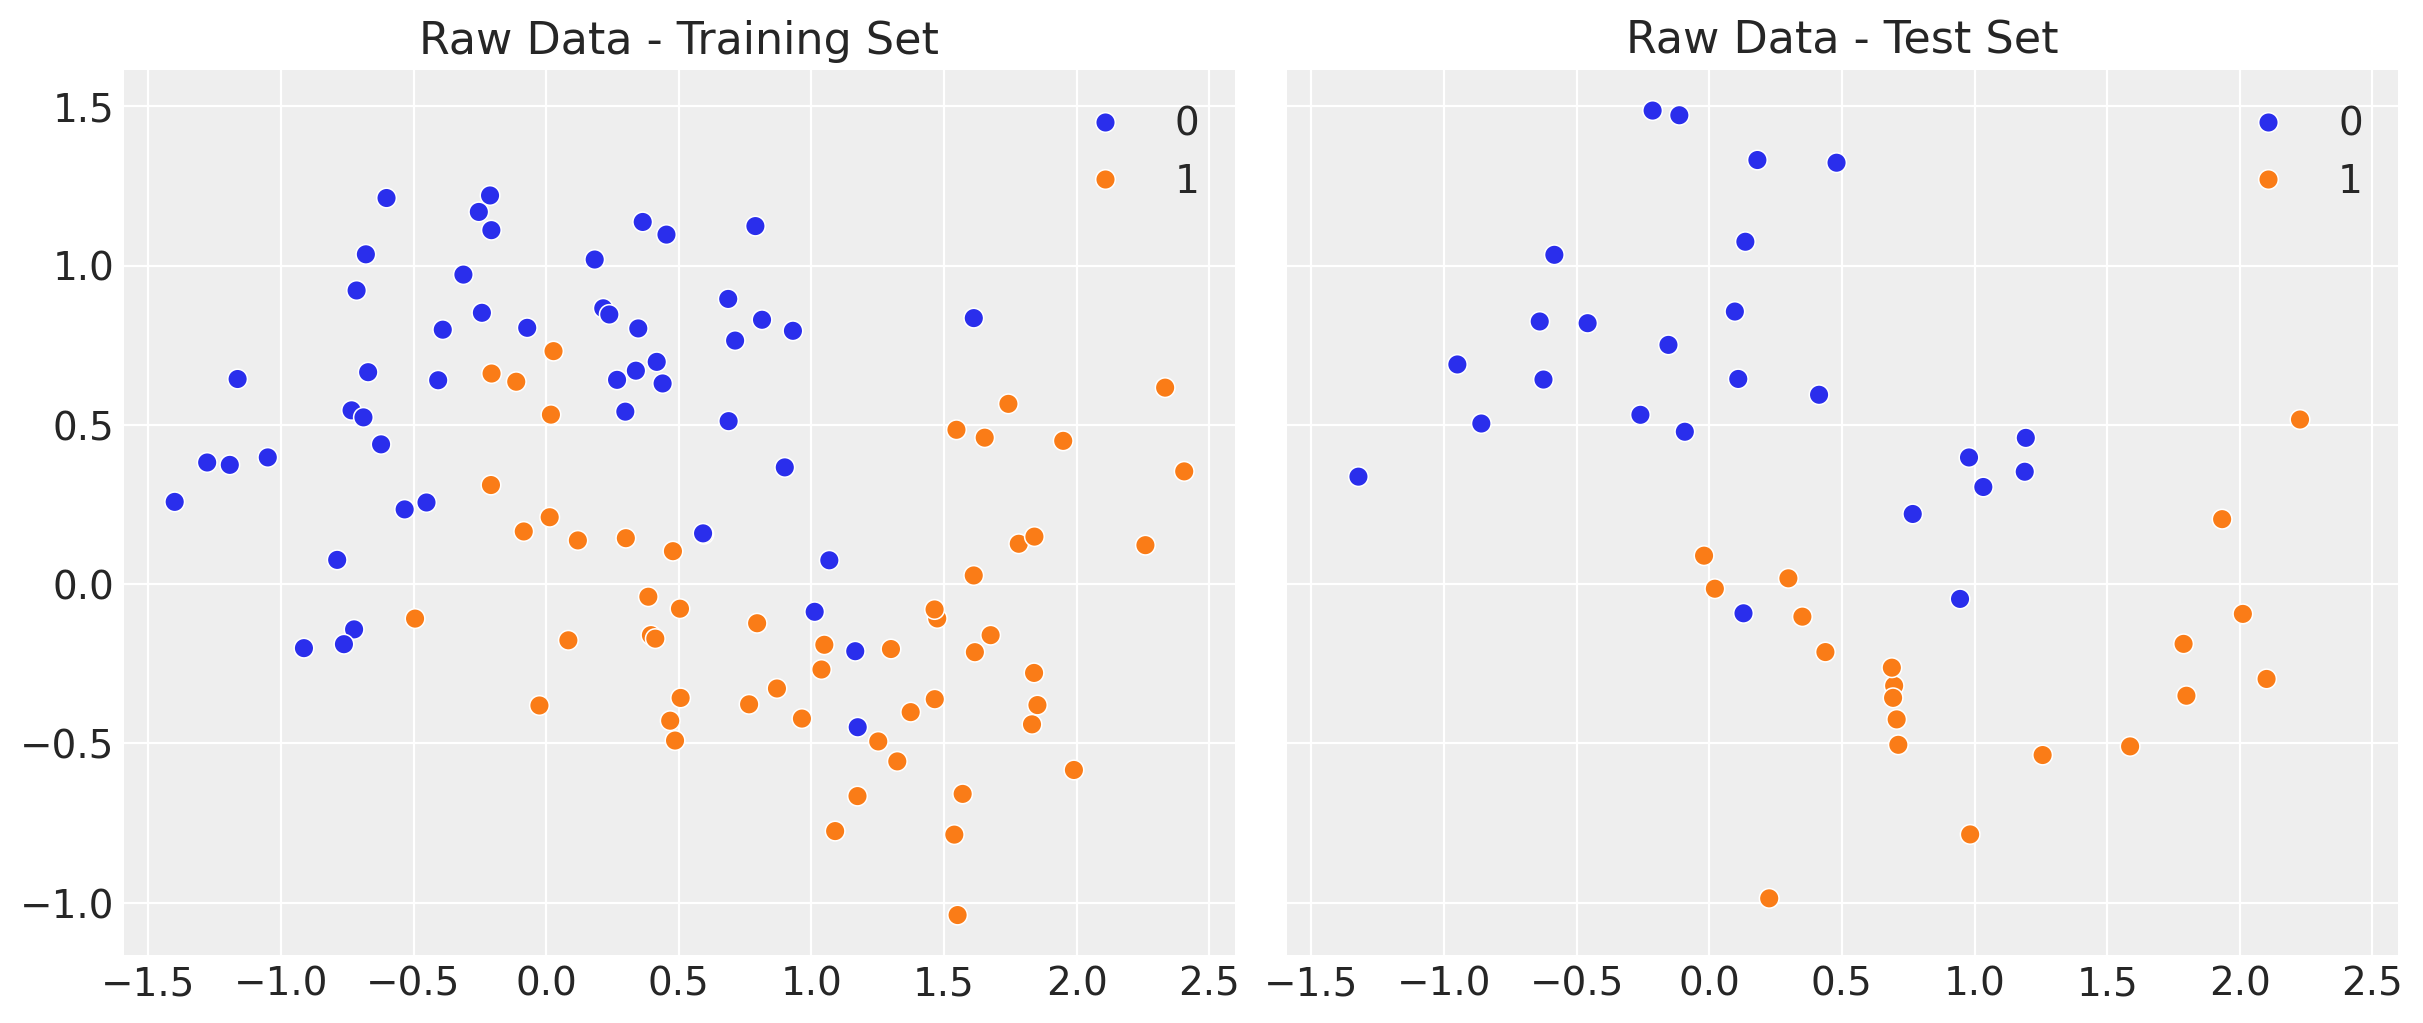

In [4]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 5),
    sharex=True,
    sharey=True,
    layout="constrained",
)
sns.scatterplot(x=x_train[:, 0], y=x_train[:, 1], s=50, hue=y_train, ax=ax[0])
ax[0].set(title="Raw Data - Training Set")
sns.scatterplot(x=x_test[:, 0], y=x_test[:, 1], s=50, hue=y_test, ax=ax[1])
ax[1].set(title="Raw Data - Test Set");

The idea is to develop a classifier to separate the two classes in the moons dataset.

## Model Specification

We use a [Hilbert Space Gaussian Process](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/HSGP-Basic.html) model with a [Matern 5/2 kernel](https://www.pymc.io/projects/docs/en/stable/api/gp/generated/pymc.gp.cov.Matern52.html). If you want to learn more about Hilbert Space Gaussian Processes, you can check the example notebook [Gaussian Processes: HSGP Reference & First Steps](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/HSGP-Basic.html) from the PyMC documentation. For a more detailed explanation, see the previous blogpost [A Conceptual and Practical Introduction to Hilbert Space GPs Approximation Methods](https://juanitorduz.github.io/hsgp_intro/).


One of the most important parameters we need to consider is the length scale of the kernel. We can use the [`pz.maxent`](https://preliz.readthedocs.io/en/stable/examples/gallery/direct_elicitation_1D.html) function to find the maximum entropy distribution for the length scale parameter given constraints on the support of the distribution.

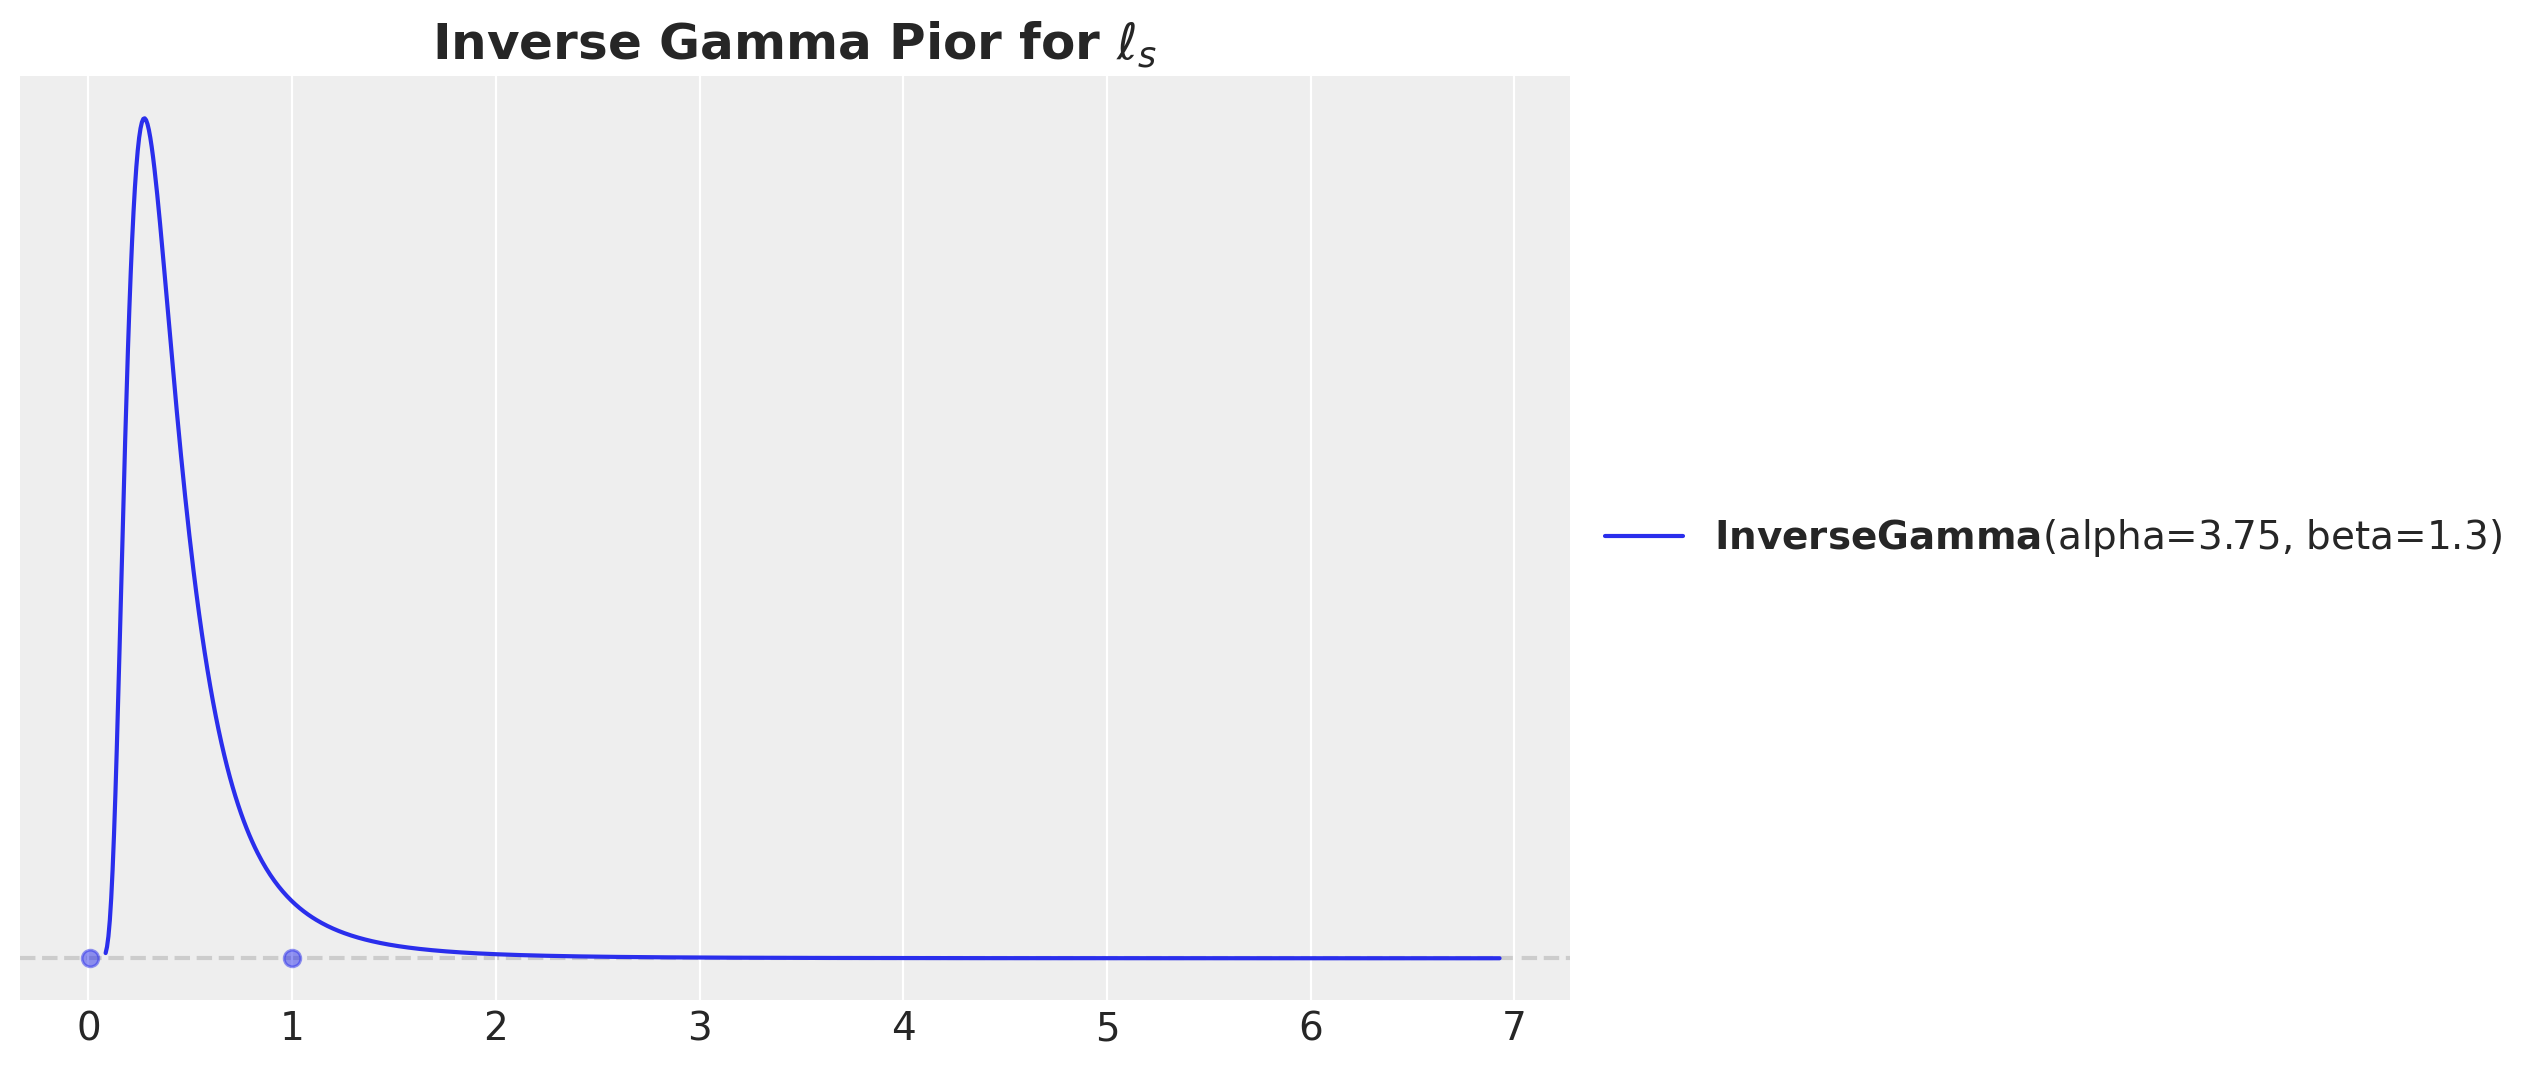

In [5]:
# We want to model distances within a range of 0.01 and 1.
fig, ax = plt.subplots()
ls_params, ax = pz.maxent(pz.InverseGamma(), lower=0.01, upper=1, mass=0.94, ax=ax)
ax.set_title(r"Inverse Gamma Pior for $\ell_{s}$", fontsize=18, fontweight="bold");

Now, we can specify the model.

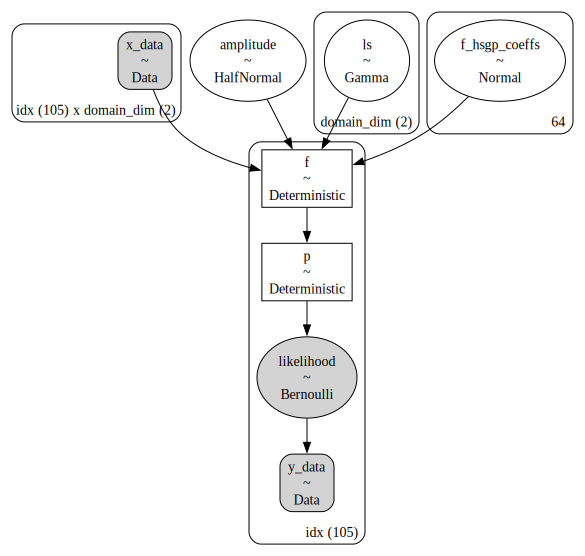

In [6]:
coords = {"domain_dim": range(domain_dim), "idx": idx_train}

with pm.Model(coords=coords) as model:
    # --- Data Containers ---
    x_data = pm.Data("x_data", x_train, dims=("idx", "domain_dim"))
    y_data = pm.Data("y_data", y_train, dims="idx")

    # --- Priors ---
    amplitude = pm.HalfNormal(name="amplitude", sigma=1)
    ls = pm.Gamma(
        name="ls", alpha=ls_params.alpha, beta=ls_params.beta, dims="domain_dim"
    )
    cov_func = amplitude**2 * pm.gp.cov.Matern52(input_dim=domain_dim, ls=ls)

    # --- Parametrization ---
    gp = pm.gp.HSGP(m=[8, 8], c=1.2, cov_func=cov_func)
    f = gp.prior("f", X=x_data, dims="idx")
    p = pm.Deterministic(name="p", var=pm.math.invlogit(f), dims="idx")

    # --- Likelihood ---
    pm.Bernoulli(name="likelihood", p=p, observed=y_data, dims="idx")

pm.model_to_graphviz(model)

## Inferece

We now fit the model on the training data using NUTS.

In [7]:
with model:
    idata = pm.sample(
        draws=2_000,
        chains=4,
        nuts_sampler="nutpie",
        random_seed=rng,
    )
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=rng))

Progress,Draws,Divergences,Step Size,Gradients/Draw
,3000,0,0.44,7
,3000,0,0.44,7
,3000,0,0.44,15
,3000,0,0.44,7


Sampling: [likelihood]


Output()

There are no divergences and the sampling is fast. Let's look at the trace:

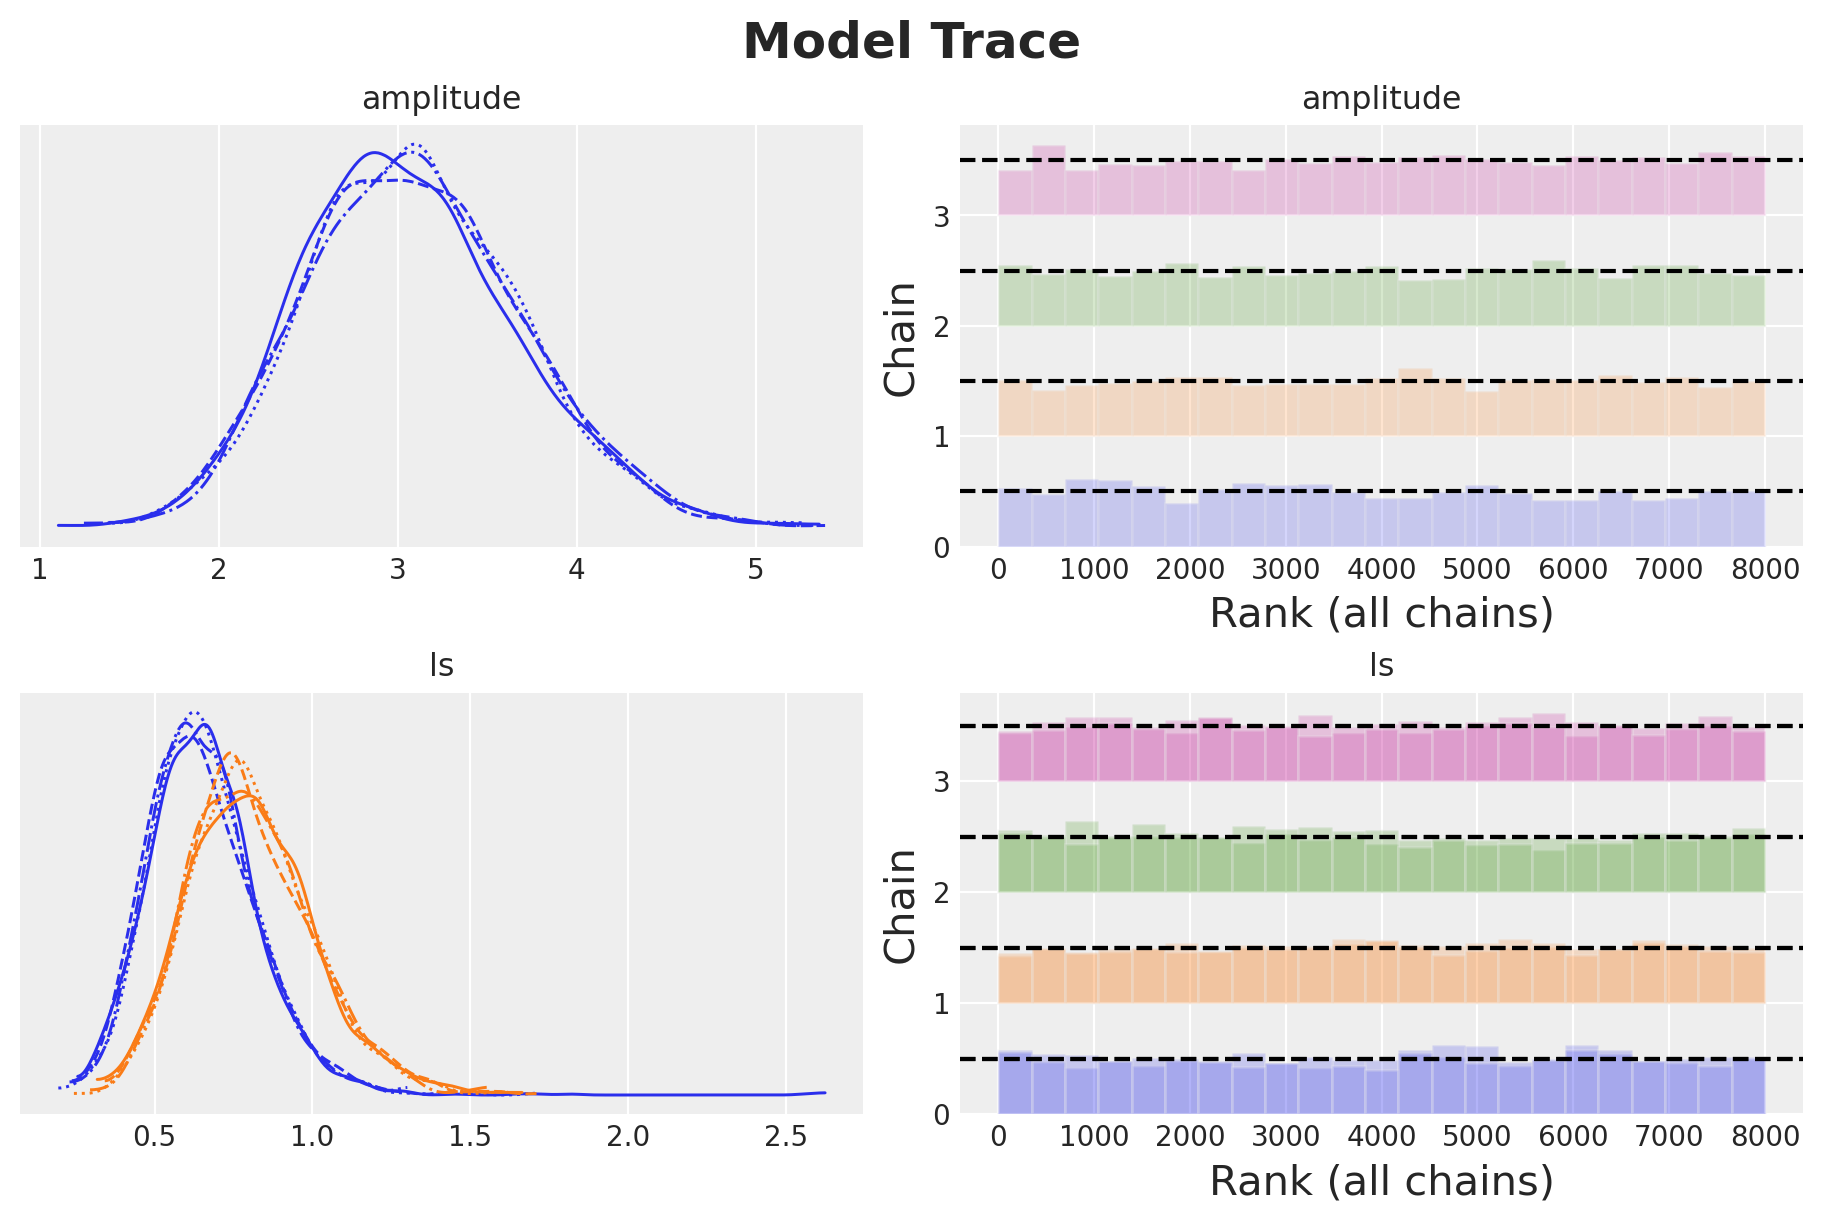

In [8]:
_ = az.plot_trace(
    data=idata,
    var_names=[
        "amplitude",
        "ls",
    ],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (9, 6), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=18, fontweight="bold");

## Generate Predictions on the Test Set

We are interested in comparing the model's performance between the training and test sets. Hence, we need to generate predictions on the test set and store them in a new `idata_test` object.

In [9]:
with model:
    pm.set_data(
        new_data={"x_data": x_test, "y_data": y_test},
        coords={"idx": idx_test},
    )

    idata_test = pm.sample_posterior_predictive(
        trace=idata,
        var_names=["p", "likelihood"],
        random_seed=rng,
        idata_kwargs={"coords": {"idx": idx_test}},
    )

Sampling: [likelihood]


Output()

## Predictions Comparison

A useful way to evaluate a classification model is to look into the saparation plot:

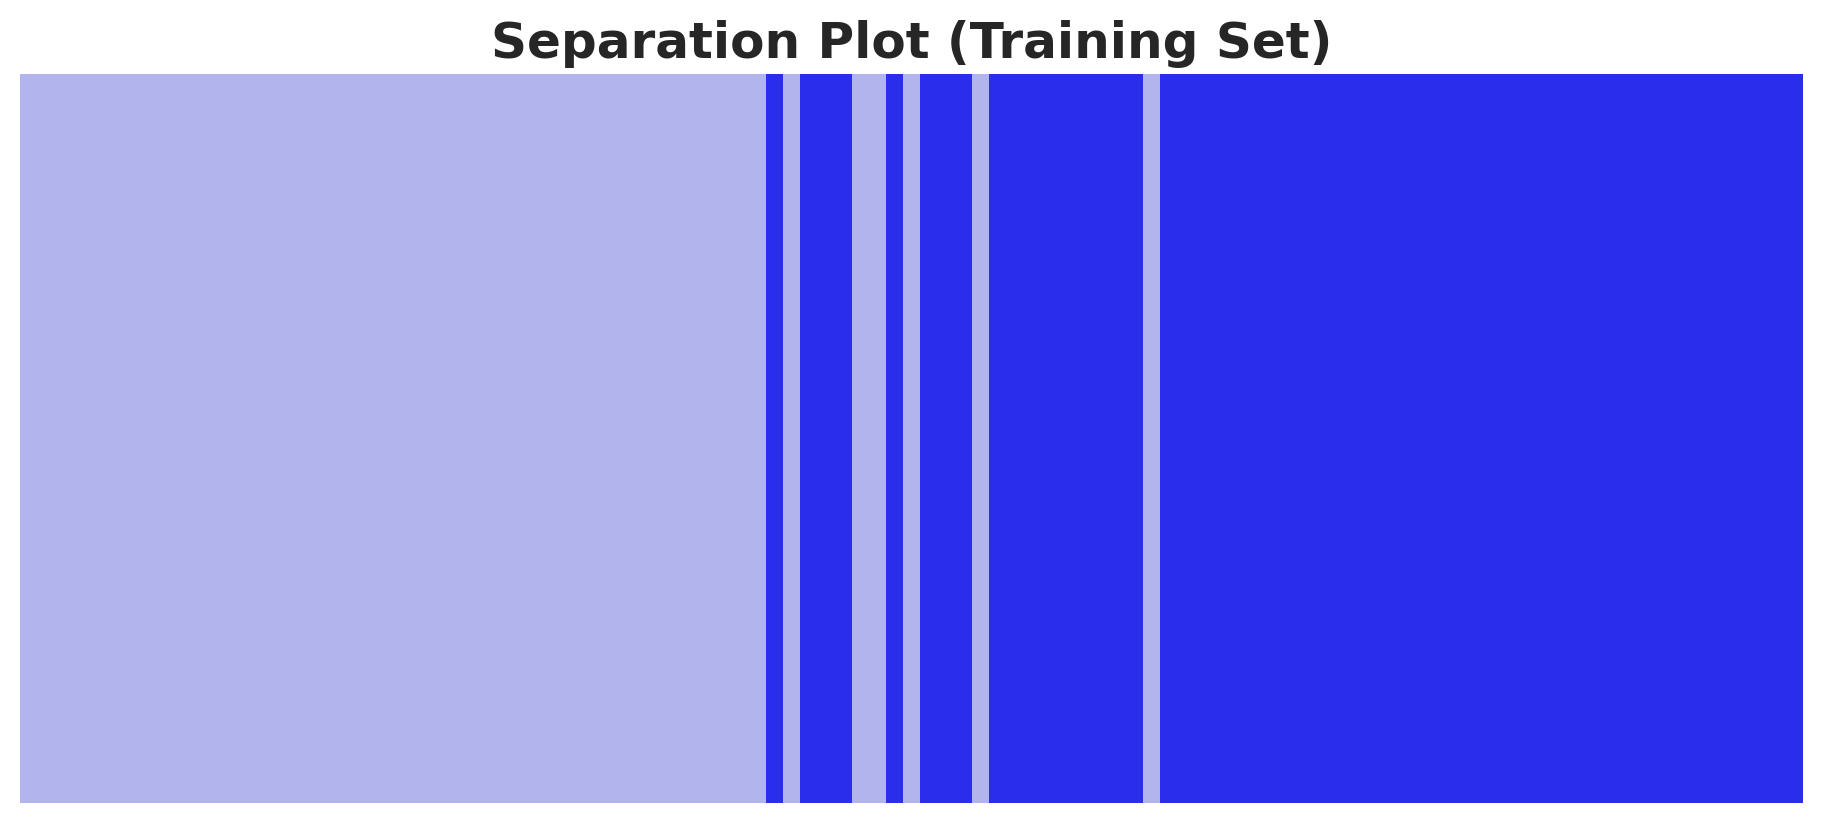

In [10]:
fig, ax = plt.subplots(figsize=(9, 4))
az.plot_separation(idata=idata, y="likelihood", ax=ax)
ax.set_title("Separation Plot (Training Set)", fontsize=18, fontweight="bold");

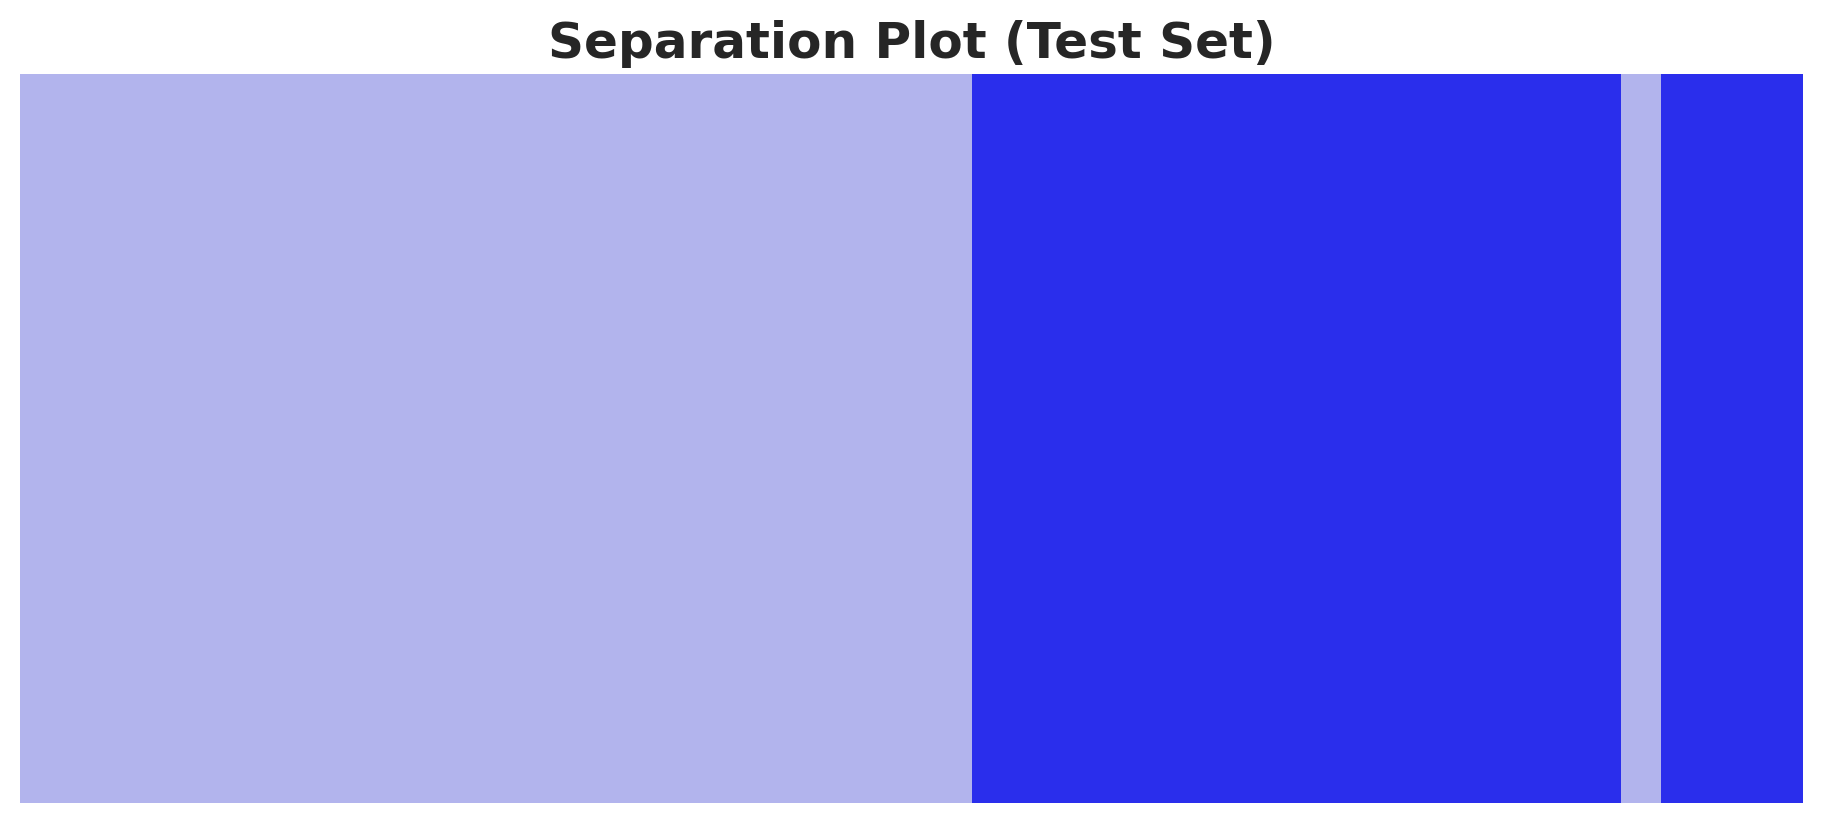

In [11]:
fig, ax = plt.subplots(figsize=(9, 4))
az.plot_separation(idata=idata_test, y="likelihood", ax=ax)
ax.set_title("Separation Plot (Test Set)", fontsize=18, fontweight="bold");

Both the training and test sets are well separated (qualitatively). Let's look into some quantitative metrics like the ROC curve and the AUC score.

### AUC Score

Here we show how to vectorize the AUC score computation over all the posterior samples. The key function is [`xr.apply_ufunc`](https://docs.xarray.dev/en/stable/generated/xarray.apply_ufunc.html) from [`xarray`](https://docs.xarray.dev/en/stable/index.html).

In [12]:
auc_train = xr.apply_ufunc(
    roc_auc_score,
    y_train,
    idata["posterior"]["p"],
    input_core_dims=[["idx"], ["idx"]],
    output_core_dims=[[]],
    vectorize=True,
)

auc_test = xr.apply_ufunc(
    roc_auc_score,
    y_test,
    idata_test["posterior_predictive"]["p"],
    input_core_dims=[["idx"], ["idx"]],
    output_core_dims=[[]],
    vectorize=True,
)

Let's look into the results and compare them with the AUC score on the posterior predictive mean.

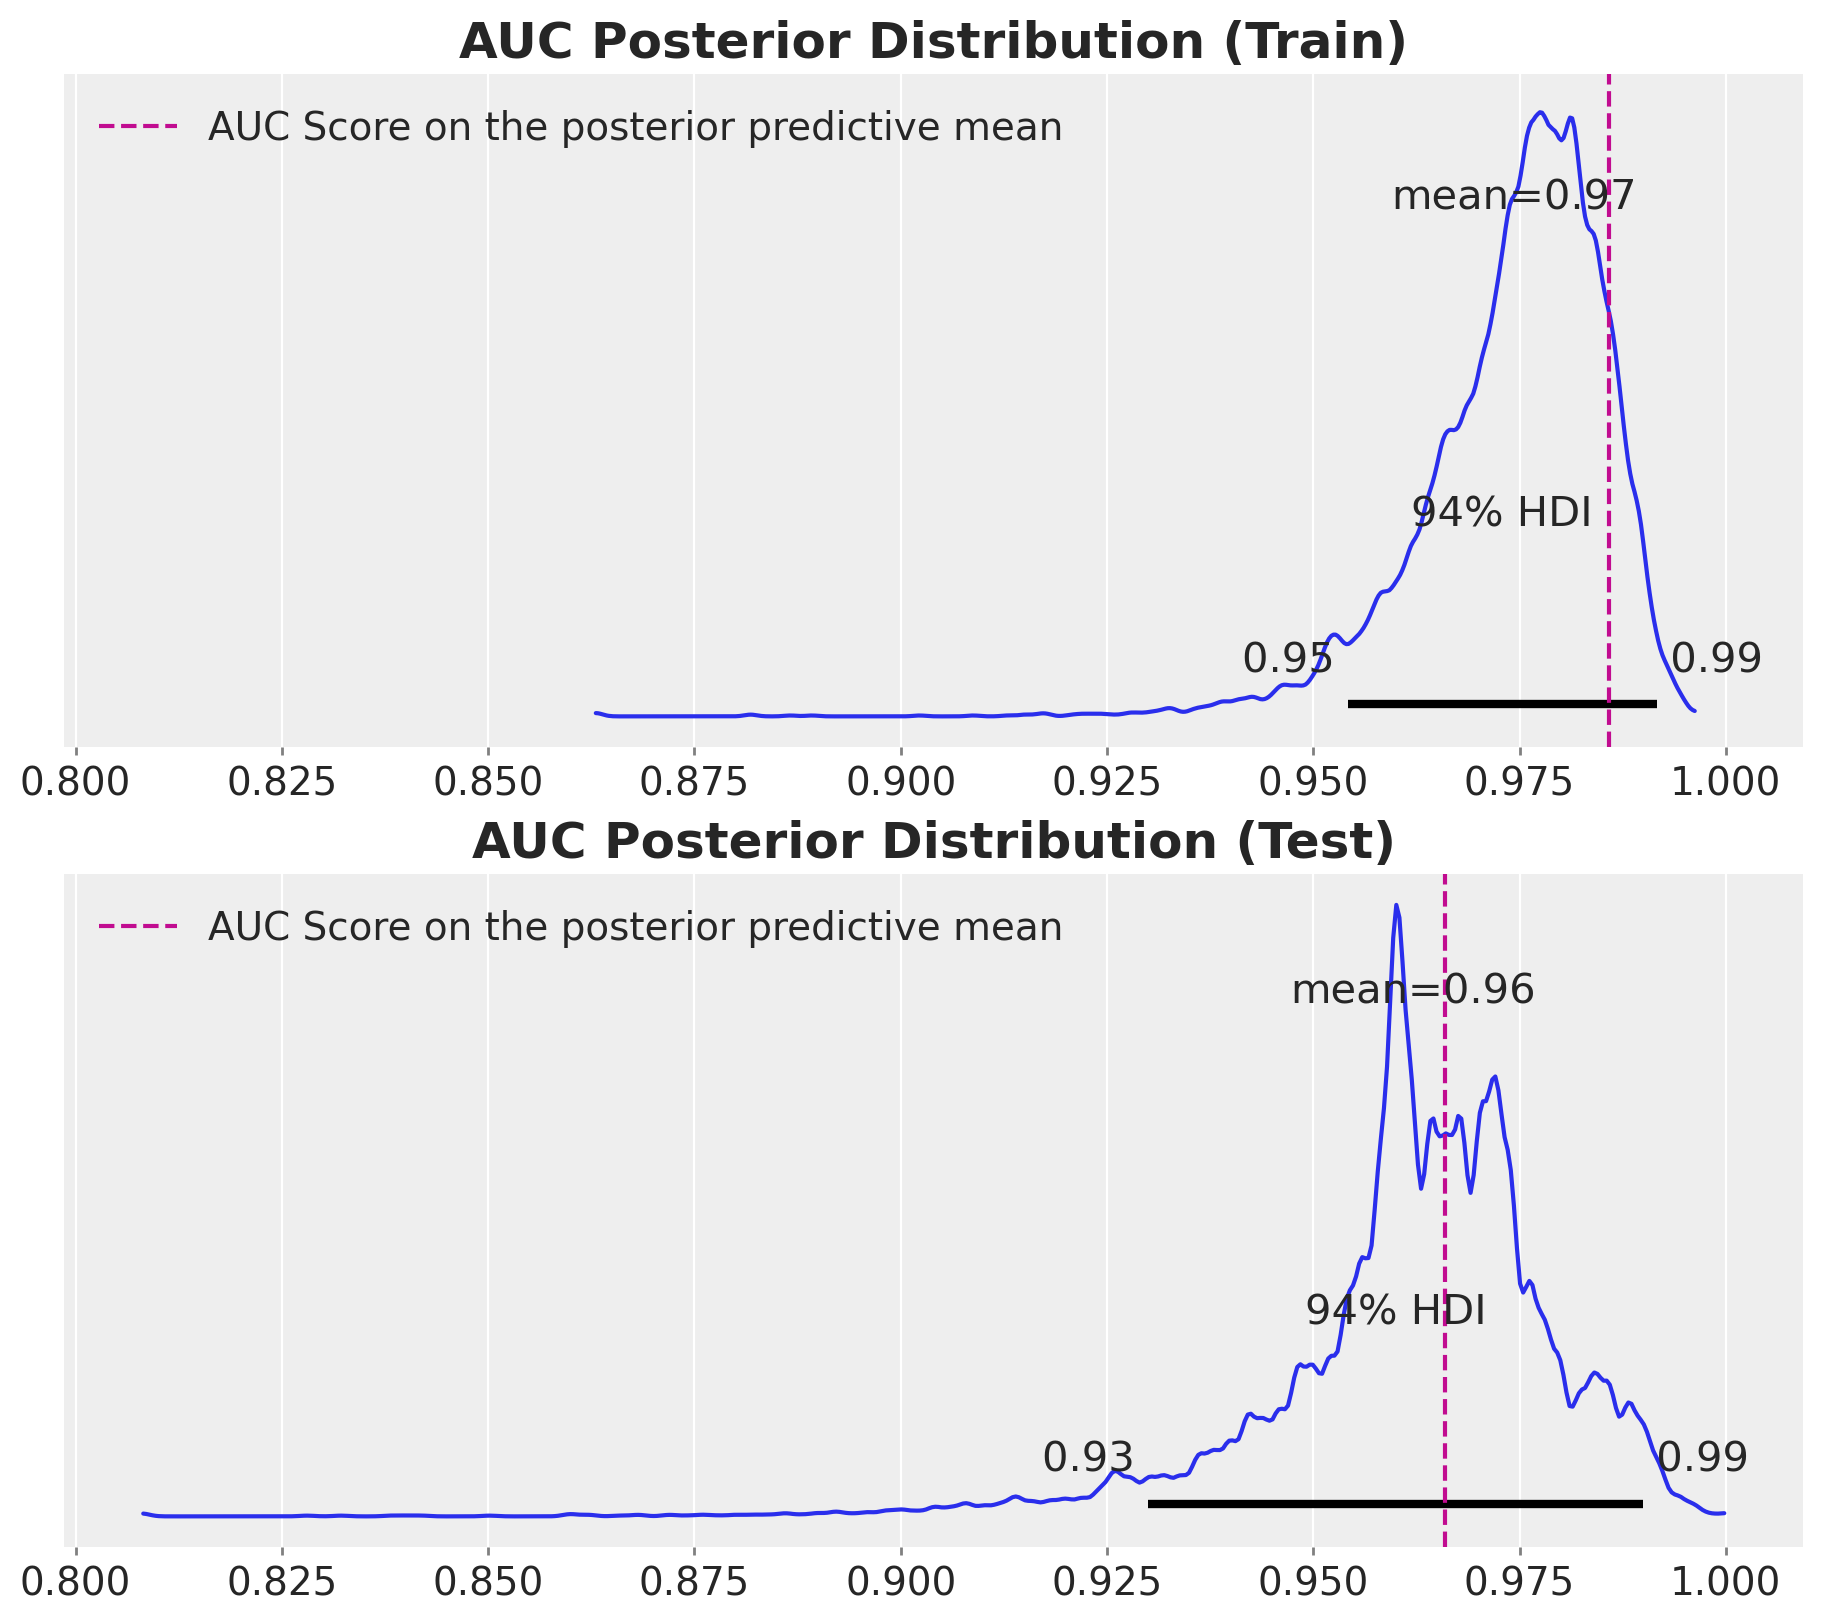

In [13]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(9, 8),
    sharex=True,
    sharey=True,
    layout="constrained",
)
az.plot_posterior(data=auc_train, ax=ax[0])
ax[0].axvline(
    roc_auc_score(y_train, idata["posterior"]["p"].mean(dim=("chain", "draw"))),
    color="C3",
    linestyle="--",
    label="AUC Score on the posterior predictive mean",
)
ax[0].legend(loc="upper left")
ax[0].set_title("AUC Posterior Distribution (Train)", fontsize=18, fontweight="bold")

az.plot_posterior(data=auc_test, ax=ax[1])
ax[1].axvline(
    roc_auc_score(
        y_test, idata_test["posterior_predictive"]["p"].mean(dim=("chain", "draw"))
    ),
    color="C3",
    linestyle="--",
    label="AUC Score on the posterior predictive mean",
)
ax[1].legend(loc="upper left")
ax[1].set_title("AUC Posterior Distribution (Test)", fontsize=18, fontweight="bold");

The model performance is good. Note that instead of having a single AUC score, we have a distribution of AUC scores. This is very usefull as we are encoding the uncertainty of the model itself. For instance, we see that the $94\%$ of the AUC score in the test set is wider than the one in the training set.

### ROC Curve

We can also vectorize the ROC curve computation.



In [14]:
fpr_train, tpr_train, thresholds_train = xr.apply_ufunc(
    lambda x, y: roc_curve(y_true=x, y_score=y, drop_intermediate=False),
    y_train,
    idata["posterior"]["p"],
    input_core_dims=[["idx"], ["idx"]],
    output_core_dims=[["threshld"], ["threshld"], ["threshld"]],
    vectorize=True,
)

fpr_test, tpr_test, thresholds_test = xr.apply_ufunc(
    lambda x, y: roc_curve(y_true=x, y_score=y, drop_intermediate=False),
    y_test,
    idata_test["posterior_predictive"]["p"],
    input_core_dims=[["idx"], ["idx"]],
    output_core_dims=[["threshld"], ["threshld"], ["threshld"]],
    vectorize=True,
)

Now we can generate the roc curves for the training and test sets.

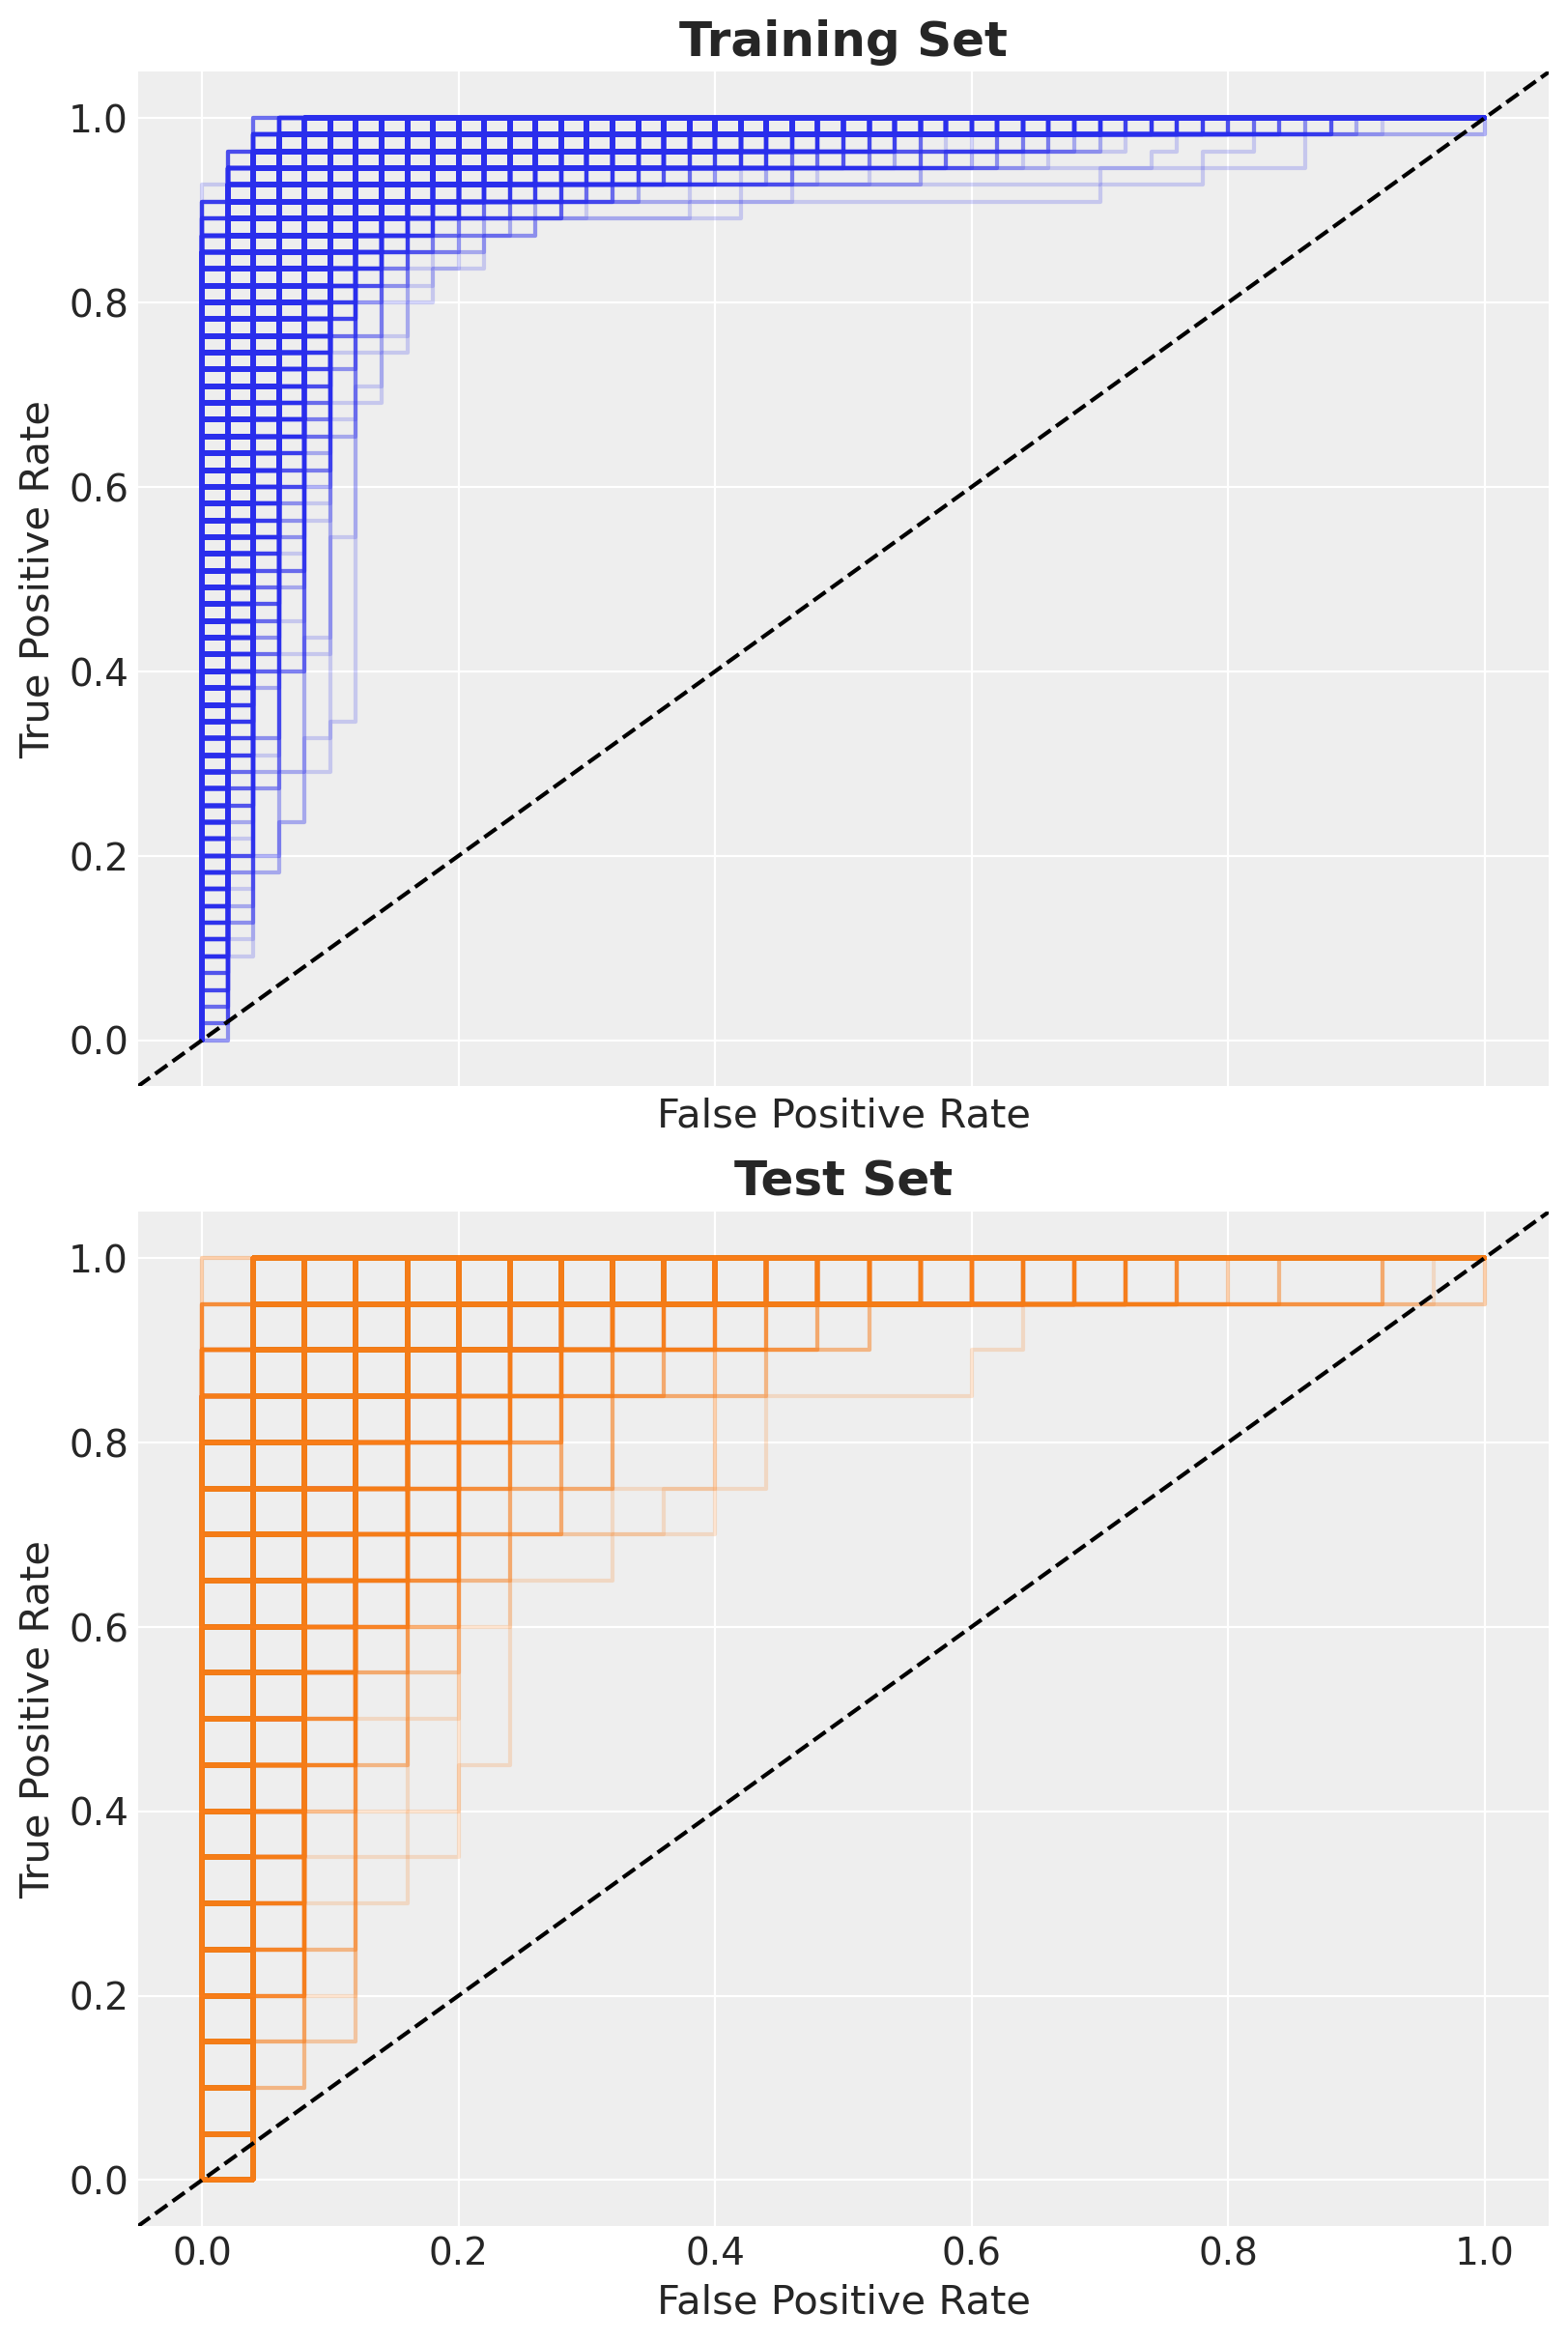

In [15]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 12),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i in range(4):
    for j in range(2_000):
        ax[0].plot(
            fpr_train.sel(chain=i, draw=j),
            tpr_train.sel(chain=i, draw=j),
            c="C0",
            alpha=0.2,
        )
        ax[1].plot(
            fpr_test.sel(chain=i, draw=j),
            tpr_test.sel(chain=i, draw=j),
            c="C1",
            alpha=0.2,
        )


ax[0].axline(
    (0, 0),
    (1, 1),
    color="black",
    linestyle="--",
)

ax[0].set(xlabel="False Positive Rate", ylabel="True Positive Rate")
ax[0].set_title("Training Set", fontsize=18, fontweight="bold")

ax[1].axline(
    (0, 0),
    (1, 1),
    color="black",
    linestyle="--",
)

ax[1].set(xlabel="False Positive Rate", ylabel="True Positive Rate")
ax[1].set_title("Test Set", fontsize=18, fontweight="bold");

## Posterior Predictive Mean

Finally, we can compute the posterior predictive mean and plot the predictions on the training and test sets.

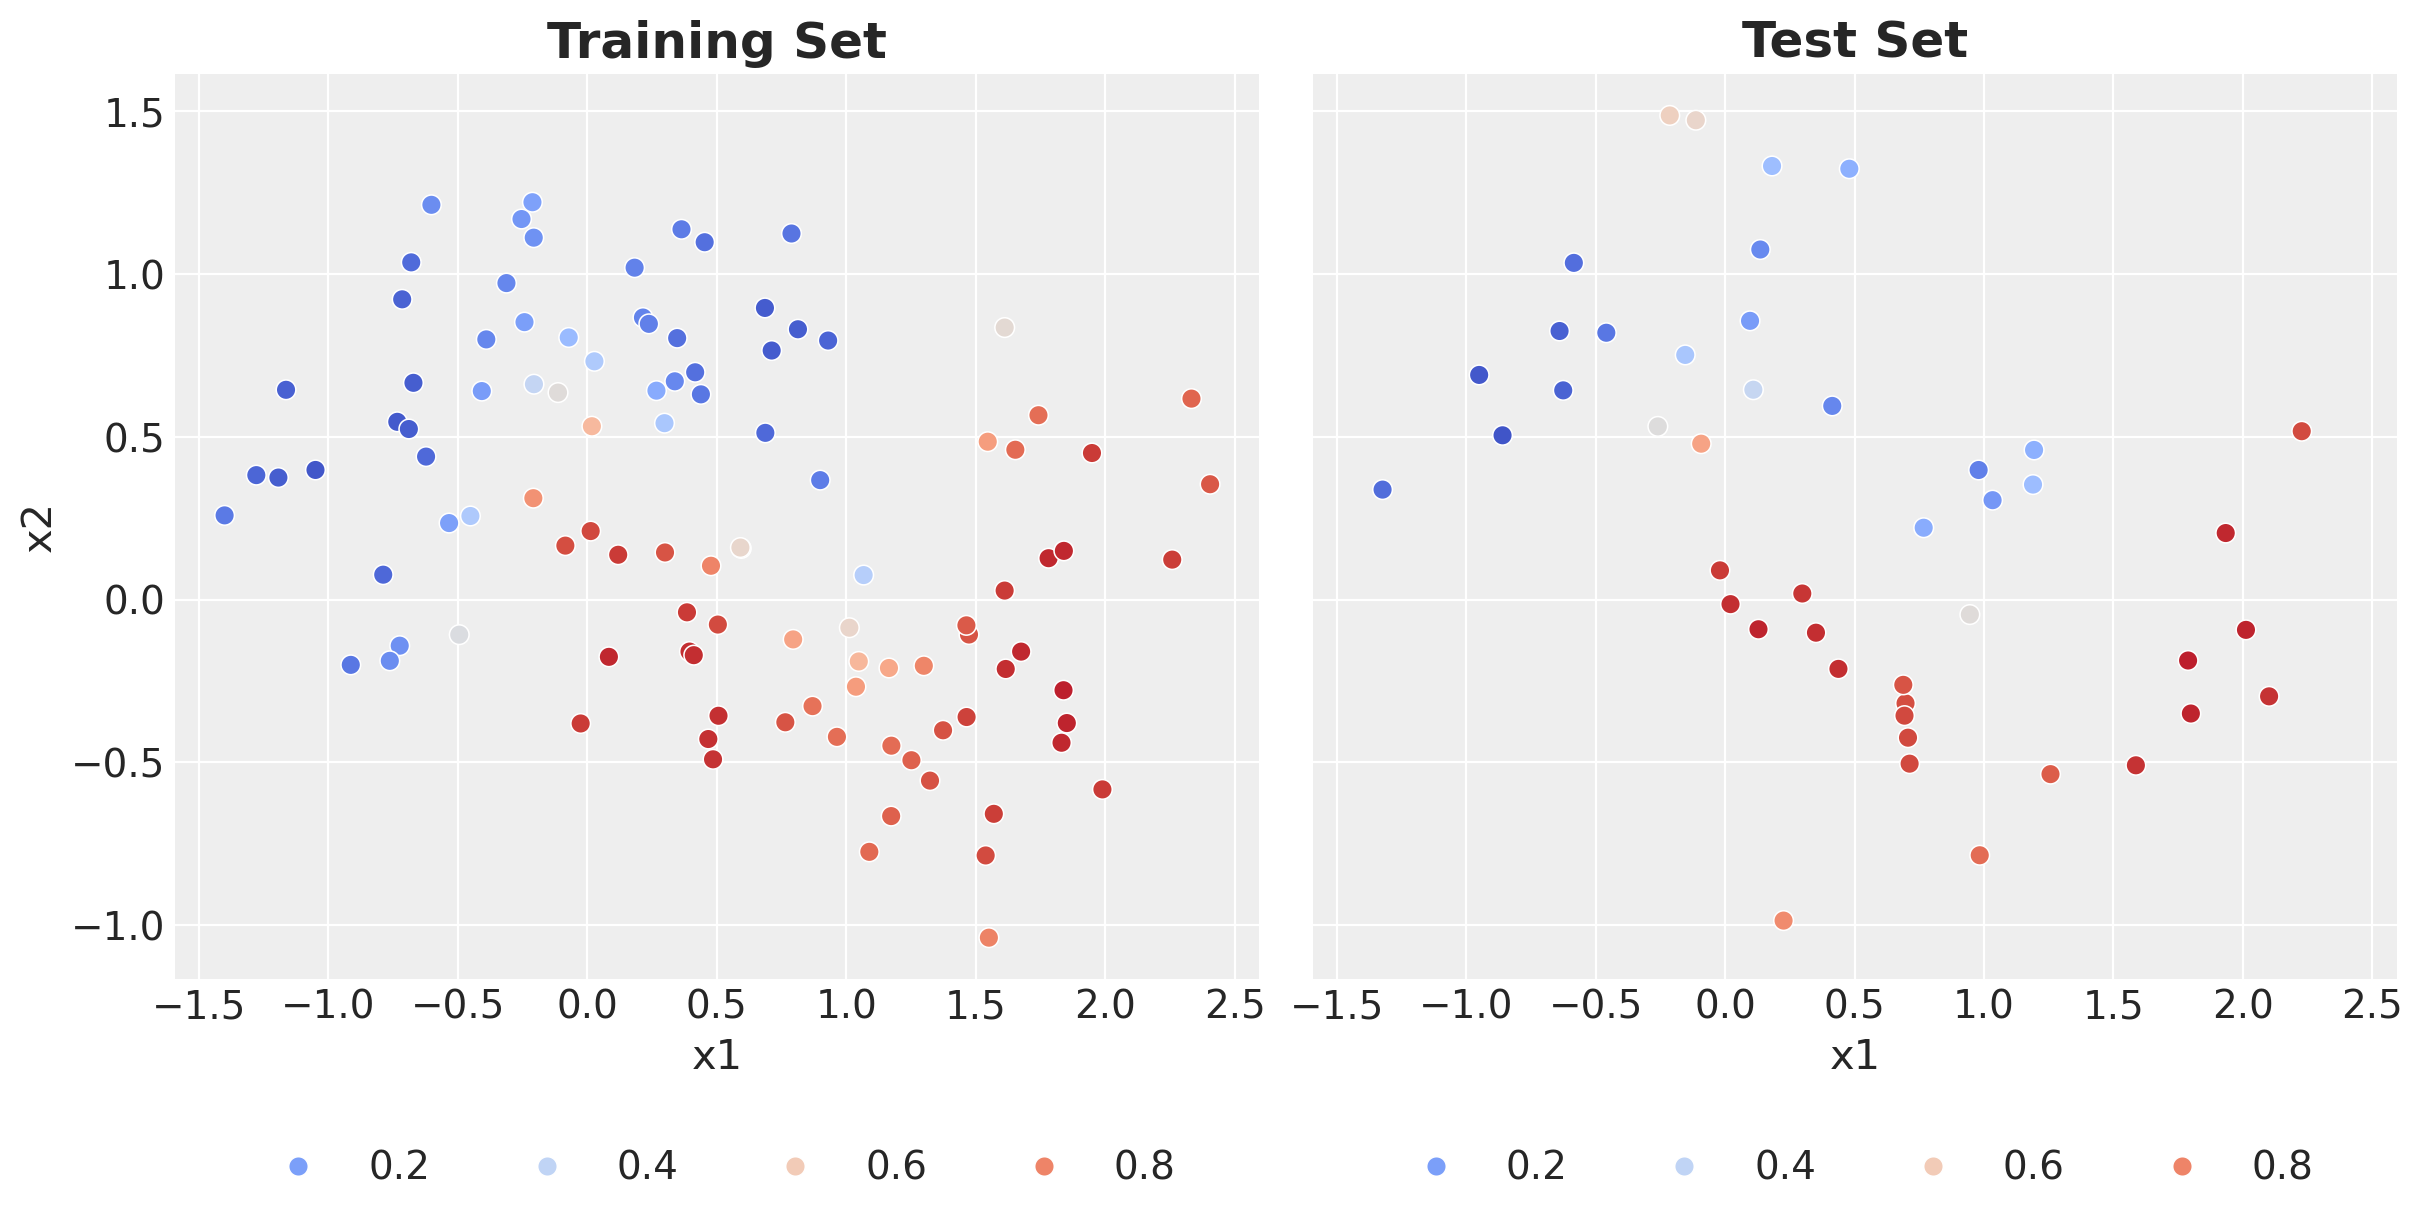

In [16]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 6),
    sharex=True,
    sharey=True,
    layout="constrained",
)

(
    idata["posterior"]["p"]
    .mean(dim=("chain", "draw"))
    .to_pandas()
    .to_frame()
    .assign(x1=x_train[:, 0], x2=x_train[:, 1])
    .pipe(
        (sns.scatterplot, "data"),
        x="x1",
        y="x2",
        hue="p",
        hue_norm=(0, 1),
        palette="coolwarm",
        s=50,
        ax=ax[0],
    )
)

ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
ax[0].set_title("Training Set", fontsize=18, fontweight="bold")

(
    idata_test["posterior_predictive"]["p"]
    .mean(dim=("chain", "draw"))
    .to_pandas()
    .to_frame()
    .assign(x1=x_test[:, 0], x2=x_test[:, 1])
    .pipe(
        (sns.scatterplot, "data"),
        x="x1",
        y="x2",
        hue="p",
        hue_norm=(0, 1),
        palette="coolwarm",
        s=50,
        ax=ax[1],
    )
)

ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
ax[1].set_title("Test Set", fontsize=18, fontweight="bold");